In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [3]:
def display(img):
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap='gray')
    
sep_coins = cv2.imread('DATA/pennies.jpg') # read images

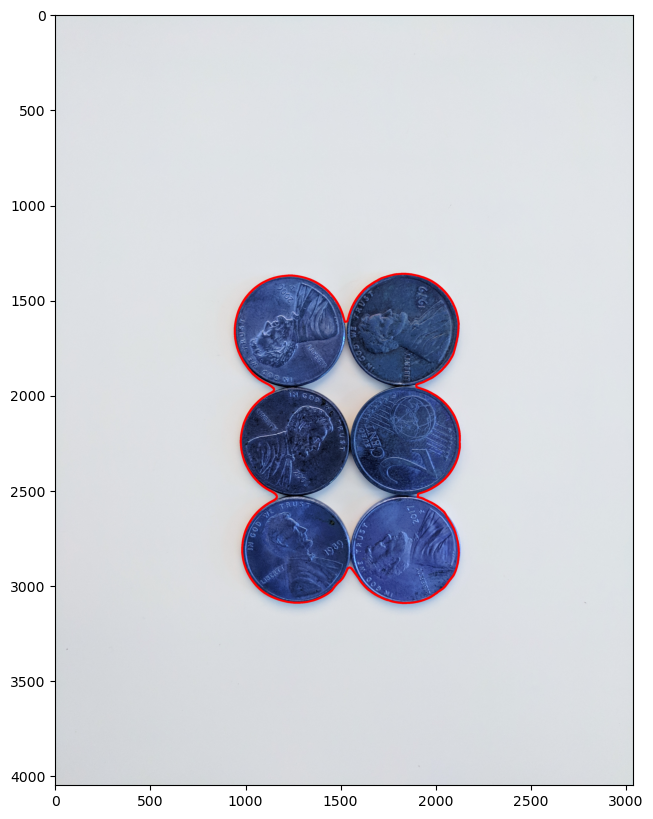

In [4]:
# Median Blur and Gray Scale Image - remove noise and convert to gray scale
sep_blur = cv2.medianBlur(sep_coins, 25)
gray_sep_coins = cv2.cvtColor(sep_blur, cv2.COLOR_BGR2GRAY)

# Binary Threshold - separeate coins as foreground from the background
ret, sep_thresh = cv2.threshold(gray_sep_coins, 160, 255, cv2.THRESH_BINARY_INV) # foreground becomes white and background becomes black

# notice that the coins are still connected to each other. - this is the main weakness of thresholding and finding contours which the watershed algorithm will solve.

# Find Contours
contours, hierarchy = cv2.findContours(sep_thresh.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

for i in range(len(contours)):
    if hierarchy[0][i][3] == -1: # last element of the hierarchy array is the external contour
        cv2.drawContours(sep_coins, contours, i, (255, 0, 0), 10) # draw the external contour

display(sep_coins) # we can see that the coins are still conjoined together :( 

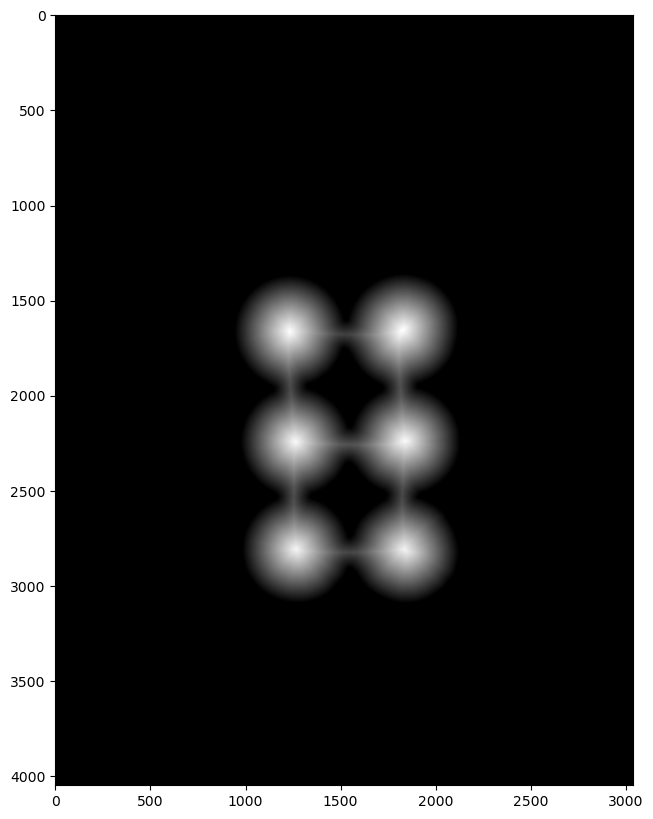

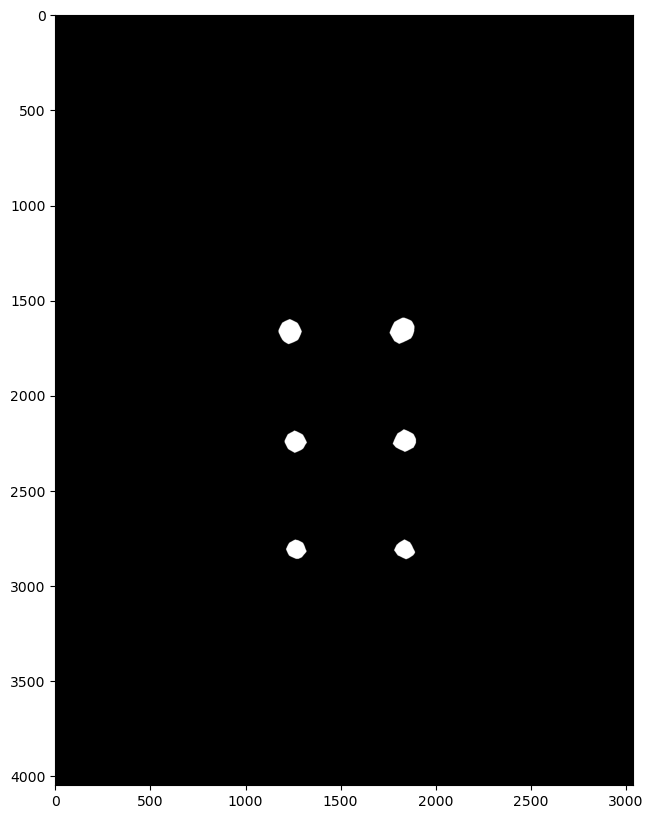

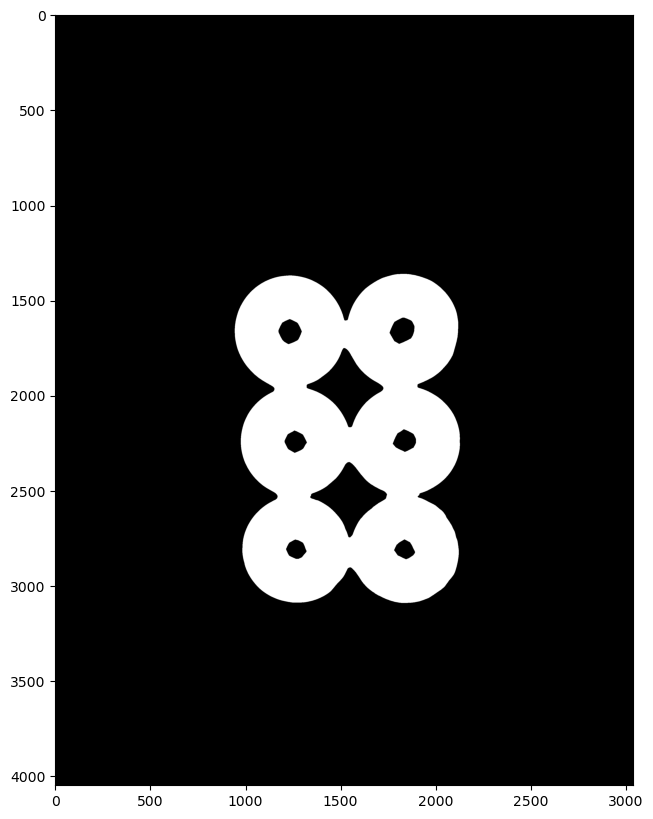

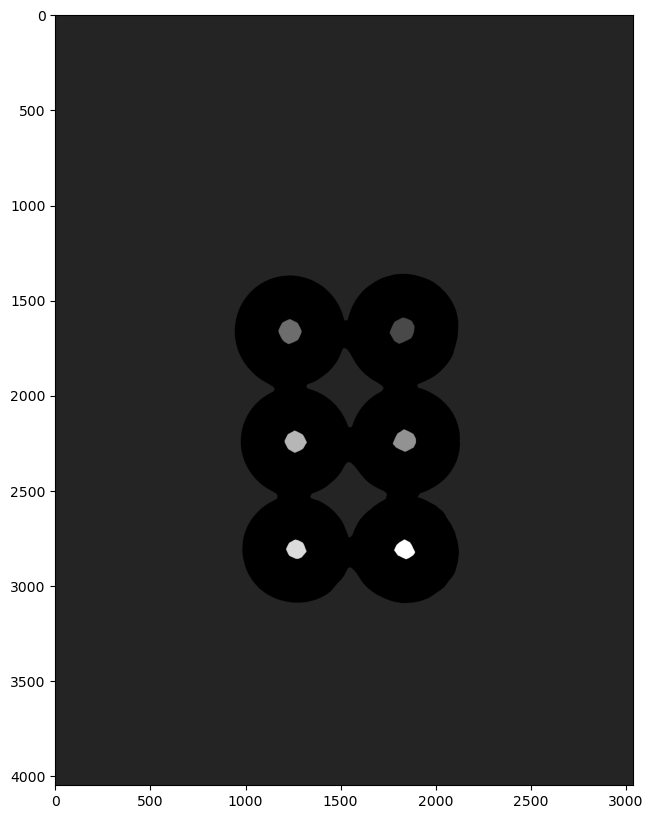

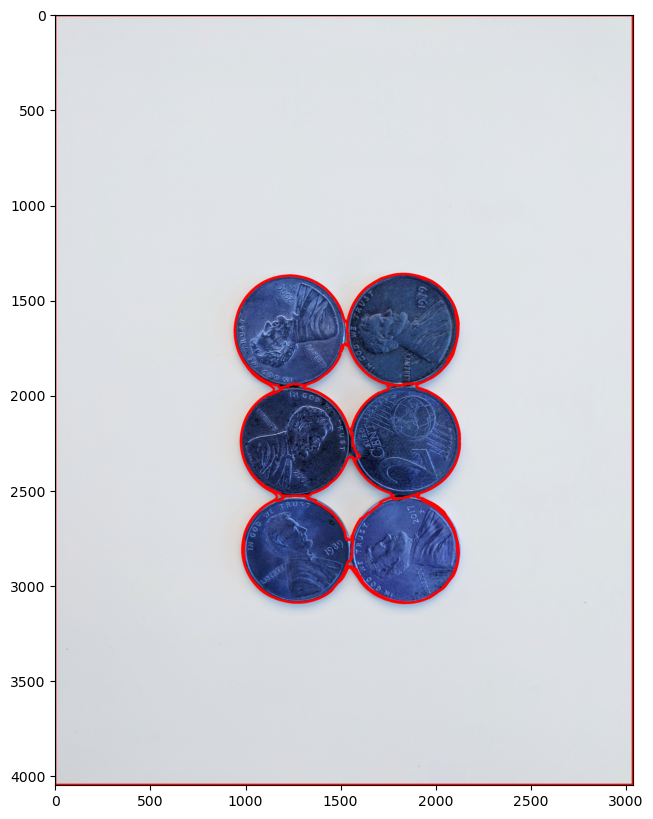

In [10]:
###### Watershed Algorithm ######
image = cv2.imread("DATA/pennies.jpg")

# Prepare Image - blur and gray scale
image = cv2.medianBlur(image, 35) # blur image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # convert to gray scale

# Threshold - inverse binary threshold and otsu's method *otsu's method works very well with the watershed algorithm
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU) # foreground becomes white and background becomes black

# Noise Removal - morphological opening (can be optional for simple images)
# kernel = np.ones((3,3), np.uint8) # create a kernel
# opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2) # apply the kernel to the image

# Distance Transform - the further away the pixels are from the background, the brighter they are - to detect the confirm foreground
dist_transform = cv2.distanceTransform(thresh, cv2.DIST_L2, 5) # 5 is the size of the kernel
display(dist_transform)

# Threshold - to obtain the cfm foreground
ret, cfm_fg = cv2.threshold(dist_transform, 0.8*dist_transform.max(), 255, 0) # foreground becomes white and background becomes black
display(cfm_fg)

# Unknown Region - the pixels that we are not sure if they are foreground or background
cfm_fg = np.uint8(cfm_fg) # convert to uint8
unknown = cv2.subtract(thresh, cfm_fg) # subtract the foreground from the threshold image
display(unknown)

# Marker Labelling - label the background and foreground
ret, markers = cv2.connectedComponents(cfm_fg) # label the foreground
markers = markers + 1 # add 1 to the background - make the sure background 1, not 0 so that we can mark the unknown region as 0
markers[unknown==255] = 0 # mark the unknown region as 0
display(markers)

# Watershed Algorithm
markers = cv2.watershed(image, markers) # apply the watershed algorithm

# Find Contours
contours, hierarchy = cv2.findContours(markers.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

for i in range(len(contours)):
    if hierarchy[0][i][3] == -1: # last element of the hierarchy array is the external contour
        cv2.drawContours(sep_coins, contours, i, (255, 0, 0), 10) # draw the external contour

display(sep_coins)

